In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os,pickle
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/Quora-question-pair-similarity-master')

#[1] TFIDF Weighted GLOVE

In [ ]:
#loading tfidf weighted glove
X_train = pd.read_csv('data/train_data.csv')
X_test = pd.read_csv('data/test_data.csv')
y_train = pd.read_csv('data/train_y.csv')
y_test = pd.read_csv('data/test_y.csv')
X_train = X_train.drop(columns=['q1_glove','q2_glove'])
X_test = X_test.drop(columns=['q1_glove','q2_glove'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 218)
(30000, 218)
(70000, 1)
(30000, 1)


In [ ]:
X_train.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,1,1,54,56,10,10,6.0,19.0,0.315789,2,...,0.569483,-0.426833,-2.113042,3.020969,-0.561594,-2.389376,3.596926,3.236205,-0.898927,2.942675
1,1,1,56,45,9,8,8.0,17.0,0.470588,2,...,-1.632971,0.367683,-0.584169,0.131638,1.710234,1.530932,3.821884,1.693522,-1.979285,-0.438928
2,4,3,111,96,19,17,8.0,34.0,0.235294,7,...,-1.331164,1.256921,-1.664439,-1.071017,-0.240619,0.791694,4.352497,3.575399,0.340574,1.360705


In [ ]:
X_test.head(3)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,14,14,45,51,6,7,4.0,13.0,0.307692,28,...,4.301661,1.195223,-0.934964,-1.958131,2.011388,-0.044642,6.433958,2.777264,3.060354,0.126252
1,3,1,82,53,13,9,0.0,21.0,0.000000,4,...,0.463282,0.238432,-1.404723,0.684371,-0.286216,-1.546682,3.217167,3.049570,-1.095971,1.239114
2,42,46,66,28,12,6,4.0,18.0,0.222222,88,...,-0.273843,-1.277817,-0.840587,4.317435,-1.256119,-2.103918,2.055993,3.312978,0.690488,0.328174


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #[TN FP]
    #[FN TP]   
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #precision = true positive / predicted positive
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #recall = true positive/ actual positive
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.4026420585616658
For values of alpha =  0.0001 The log loss is: 0.41341660950742587
For values of alpha =  0.001 The log loss is: 0.4169792889338838
For values of alpha =  0.01 The log loss is: 0.3903866097213397
For values of alpha =  0.1 The log loss is: 0.41545283751354894
For values of alpha =  1 The log loss is: 0.4518802517826623
For values of alpha =  10 The log loss is: 0.5152831715678602


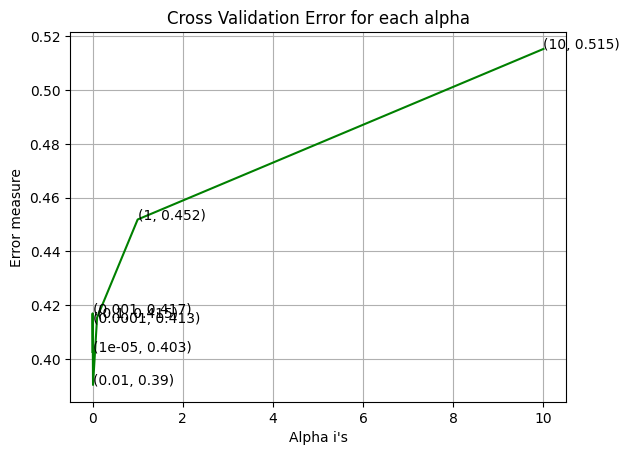

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.3843258293183725
For values of best alpha =  0.01 The test log loss is: 0.3903866097213397
Total number of data points : 30000


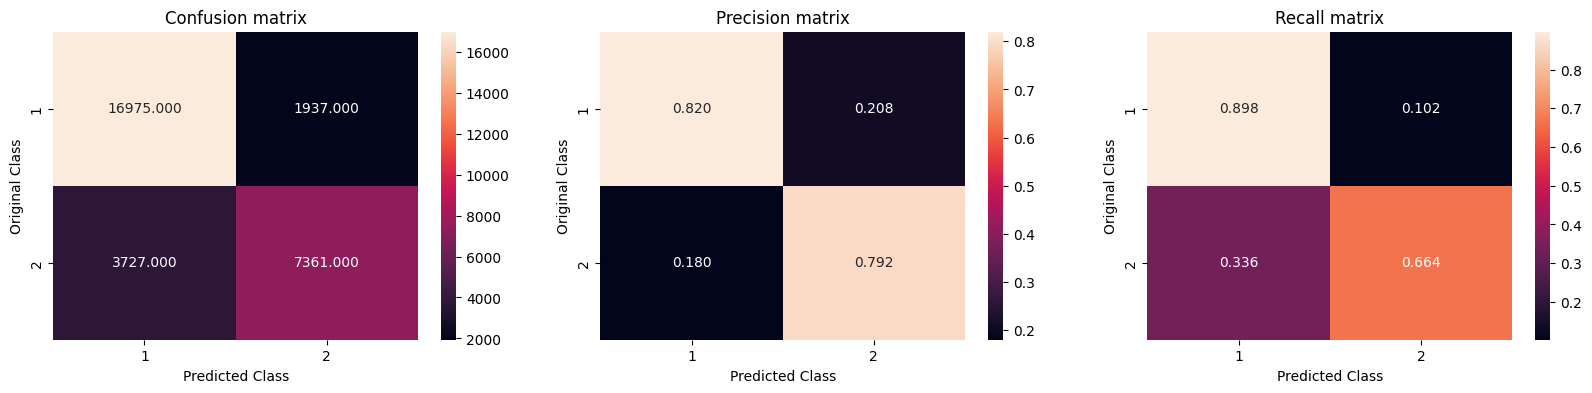

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Interpretation of precision matrix:

* Of all the points predicted as class1 17% belongs to class 2 and 82% is predicted correct as class1.

* Similarly of all points predicted as class2 78% belongs to class2 and 21% belongs to class1.

Recall matrix:
* Of all actual points belonging to class 1, 89.3% is precied as class 1 and rest 10.7% as class2.
* Similarly, Of all the actual points belonging to class 2, 31% is predicted as class 1 and 66.9% as class2.

## Linear SVM with hinge Loss

For values of alpha =  1e-05 The log loss is: 0.4017455045172091
For values of alpha =  0.0001 The log loss is: 0.4099132256466031
For values of alpha =  0.001 The log loss is: 0.4132846483729001
For values of alpha =  0.01 The log loss is: 0.392458437620356
For values of alpha =  0.1 The log loss is: 0.4146221363836294
For values of alpha =  1 The log loss is: 0.440980076530889
For values of alpha =  10 The log loss is: 0.4951151847450024


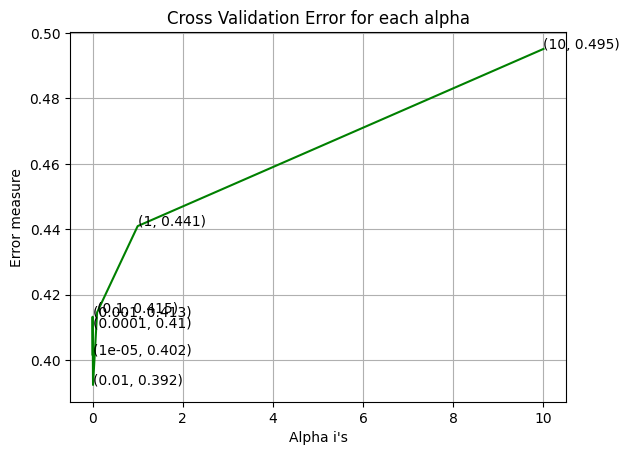

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.387343333576651
For values of best alpha =  0.01 The test log loss is: 0.392458437620356
Total number of data points : 30000


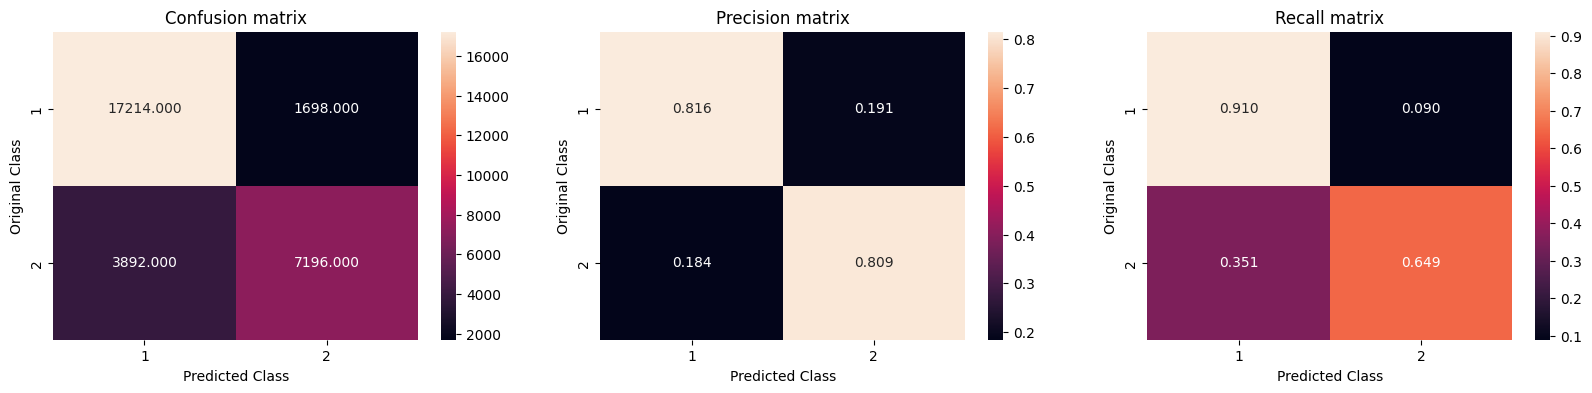

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost Classifier

In [ ]:

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = {
        'max_depth': [i for i in range(1,8,2)],
        'n_estimators' : [i*10 for i in range(1, 10)],
         'gamma': [0, 0.25, 0.5, 1.0],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]         
        }
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_search = RandomizedSearchCV(xgboost_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_search.fit(X_train, y_train)

print("Best score : ",xgb_search.best_score_)
print("Best Parameters",xgb_search.best_params_)

Best score :  -0.3119965626668666
Best Parameters {'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.25}


Log loss for tfidf train data :  0.21667200942242115
Log loss for tfidf test data :  0.31909646297475824


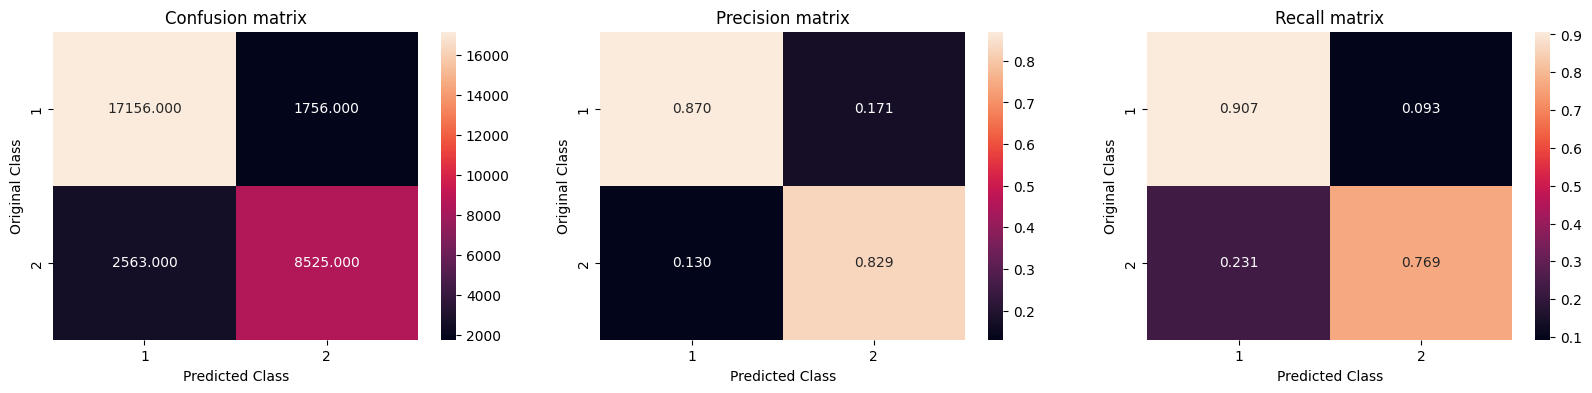

In [ ]:
clf = xgb.XGBClassifier(**xgb_search.best_params_,objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
clf.fit(X_train, y_train)   

#log loss uses a exact prob score 
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

predict_y = cal_clf.predict_proba(X_train)

print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)

print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

#[2] TFIDF Features

In [ ]:
#tfidf-w2v
X_train = pickle.load(open("data/tfidf_X_tr","rb"))
X_test = pickle.load(open("data/tfidf_X_test","rb"))
y_test = pd.read_csv('data/test_y.csv')
y_train = pd.read_csv('data/train_y.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 40000)
(30000, 40000)
(70000, 1)
(30000, 1)


## Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.5394247521413
For values of alpha =  0.0001 The log loss is: 0.5439507068818819
For values of alpha =  0.001 The log loss is: 0.5717202692438471
For values of alpha =  0.01 The log loss is: 0.5963944447526353
For values of alpha =  0.1 The log loss is: 0.6433328199387879
For values of alpha =  1 The log loss is: 0.6511025880218158
For values of alpha =  10 The log loss is: 0.6518009883305877


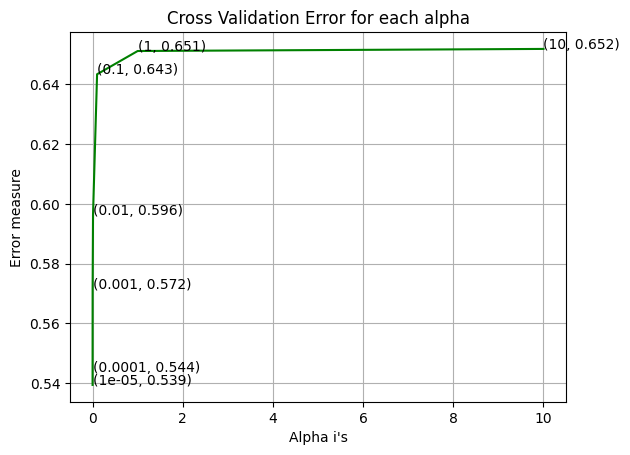

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.4362013191694408
For values of best alpha =  1e-05 The test log loss is: 0.5394247521413
Total number of data points : 30000


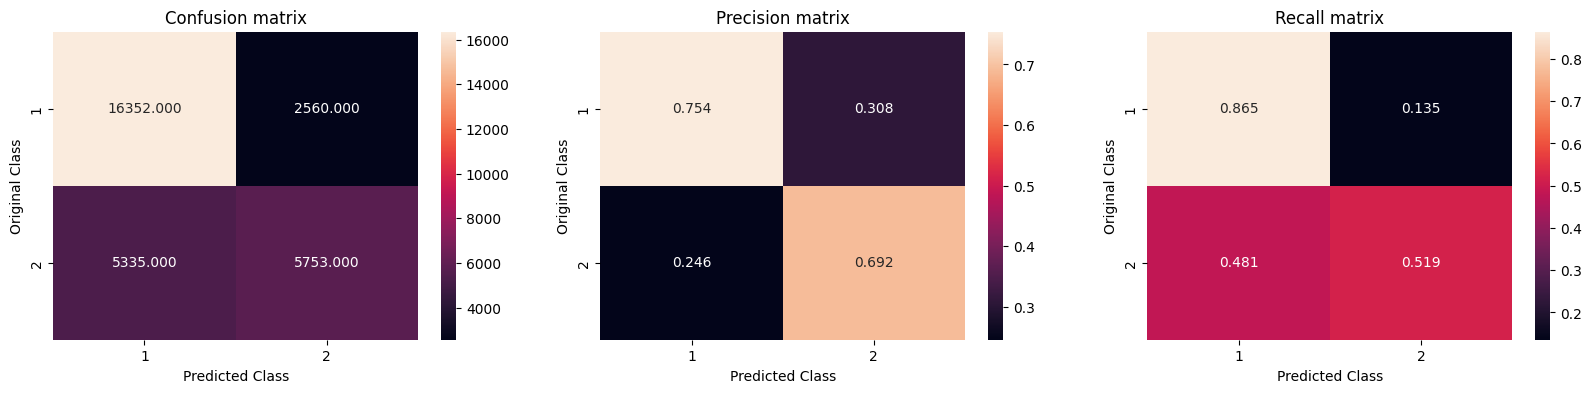

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hinge Loss

For values of alpha =  1e-05 The log loss is: 0.5525064436903558
For values of alpha =  0.0001 The log loss is: 0.5444042421387661
For values of alpha =  0.001 The log loss is: 0.5765658935650594
For values of alpha =  0.01 The log loss is: 0.5852424053491831
For values of alpha =  0.1 The log loss is: 0.6518235293362067
For values of alpha =  1 The log loss is: 0.6518235293339621
For values of alpha =  10 The log loss is: 0.6518235293361252


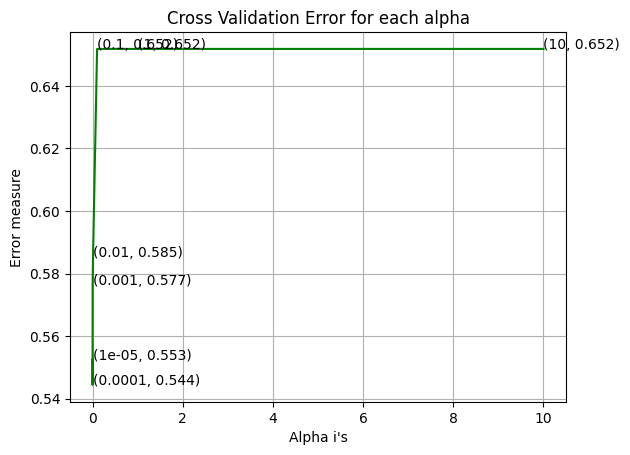

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.48846721940918764
For values of best alpha =  0.0001 The test log loss is: 0.5444042421387661
Total number of data points : 30000


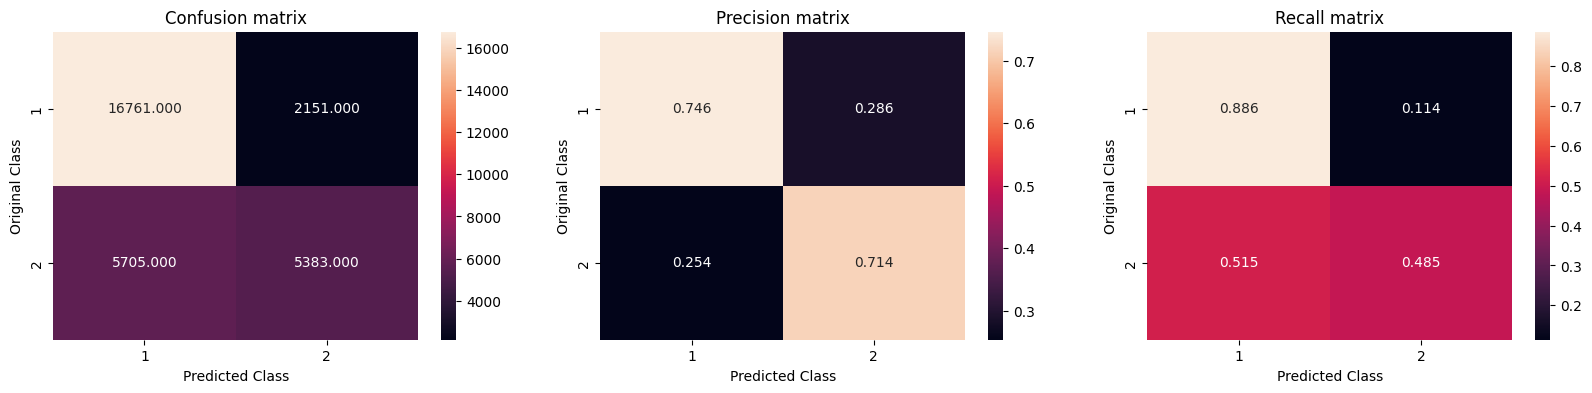

In [ ]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [ ]:

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = {
        'max_depth': [i for i in range(1,8,2)],
        'n_estimators' : [i*10 for i in range(1, 10)],
         'gamma': [0, 0.25, 0.5, 1.0],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]         
        }
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_search = RandomizedSearchCV(xgboost_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_search.fit(X_train, y_train)

print("Best score : ",xgb_search.best_score_)
print("Best Parameters",xgb_search.best_params_)

Best score :  -0.5264510761513538
Best Parameters {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.5}


Log loss for tfidf train data :  0.4560244719803746
Log loss for tfidf test data :  0.5163395992548884


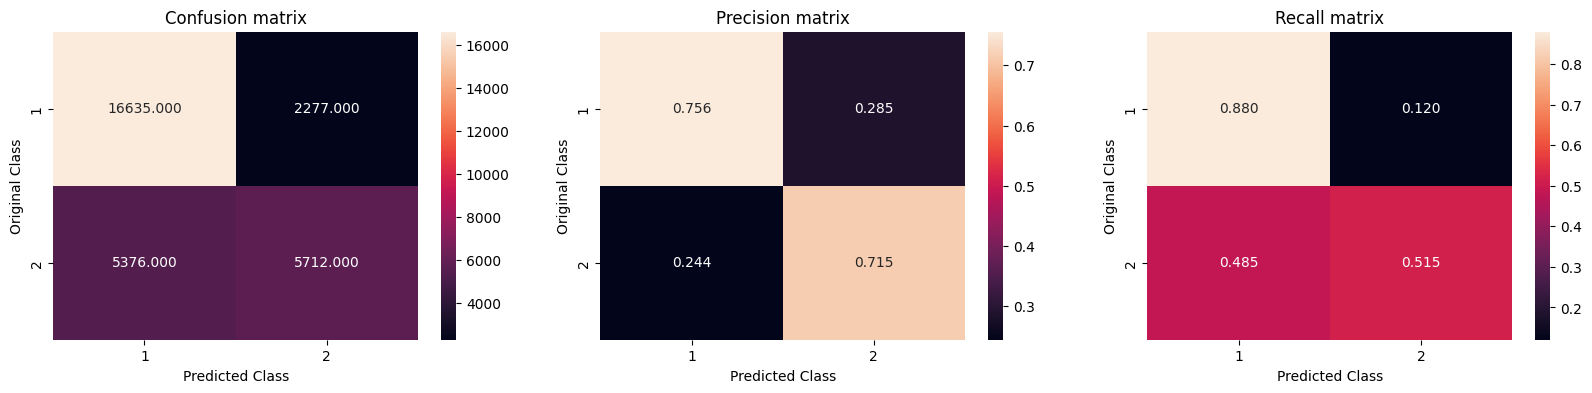

In [ ]:
clf = xgb.XGBClassifier(**xgb_search.best_params_,objective='binary:logistic', eval_metric='logloss',n_jobs=-1)
clf.fit(X_train, y_train)   

#log loss uses a exact prob score 
cal_clf = CalibratedClassifierCV(clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

predict_y = cal_clf.predict_proba(X_train)

print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = cal_clf.predict_proba(X_test)

print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [ ]:
from prettytable import PrettyTable
print("TF-IDF w2v")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF w2v', 0.3843258293183725, 0.3903866097213397])
x.add_row(["Linear SVM", 'TF-IDF w2v', 0.387343333576651, 0.392458437620356])
x.add_row(["XGBoost", 'TF-IDF w2v', 0.21667200942242115,0.31909646297475824])
print(x)


print("\n TF-IDF vec")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss"]

x.add_row(["Logistic Regression",'TF-IDF ', 0.4362013191694408,0.5394247521413])
x.add_row(["Linear SVM", 'TF-IDF ',0.48846721940918764,0.5444042421387661 ])
x.add_row(["XGBoost", 'TF-IDF ', 0.4560244719803746,0.5163395992548884])
print(x)

TF-IDF w2v
+---------------------+------------+---------------------+---------------------+
|       ML Model      | Vectorizer |    Train log loss   |    Test log loss    |
+---------------------+------------+---------------------+---------------------+
| Logistic Regression | TF-IDF w2v |  0.3843258293183725 |  0.3903866097213397 |
|      Linear SVM     | TF-IDF w2v |  0.387343333576651  |  0.392458437620356  |
|       XGBoost       | TF-IDF w2v | 0.21667200942242115 | 0.31909646297475824 |
+---------------------+------------+---------------------+---------------------+

 TF-IDF vec
+---------------------+------------+---------------------+--------------------+
|       ML Model      | Vectorizer |    Train log loss   |   Test log loss    |
+---------------------+------------+---------------------+--------------------+
| Logistic Regression |  TF-IDF    |  0.4362013191694408 |  0.5394247521413   |
|      Linear SVM     |  TF-IDF    | 0.48846721940918764 | 0.5444042421387661 |
|       X